In [14]:
import numpy as np
import pandas as pd
from joblib import dump, load
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import itertools

In [15]:
def shuffle_arrays(arr1, arr2):
    assert len(arr1) == len(arr2)
    permutation = np.random.permutation(len(arr1))
    return arr1[permutation], arr2[permutation]

# Training Dataset

In [16]:
df = pd.read_csv("../files/data/FINAL_CSV/SURFACE_CRACK_TRAIN.csv")
df

,c_index,a/c,a/t,c/b,phi,K-T
0,0.0,0.90,0.6,0.3,0.104720,40.307724
1,0.0,0.90,0.6,0.3,0.127808,39.933349
2,0.0,0.90,0.6,0.3,0.150895,39.581137
3,0.0,0.90,0.6,0.3,0.173983,39.252257
4,0.0,0.90,0.6,0.3,0.197071,38.942722
...,...,...,...,...,...,...
322299,2517.0,1.25,0.7,0.4,2.944522,42.049678
322300,2517.0,1.25,0.7,0.4,2.967609,42.477554
322301,2517.0,1.25,0.7,0.4,2.990697,42.920955
322302,2517.0,1.25,0.7,0.4,3.013785,43.379250


In [17]:
# Get unique combinations of the first four columns
SC_train_combinations = df.iloc[:, 1:4].drop_duplicates().to_numpy()

print(len(SC_train_combinations))

print("Different a/c values: ", np.unique(SC_train_combinations[:,0], axis=0))
print("Different a/t values: ", np.unique(SC_train_combinations[:,1], axis=0))
print("Different c/b values: ", np.unique(SC_train_combinations[:,2], axis=0))

2518
Different a/c values:  [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55
 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
Different a/t values:  [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85]
Different c/b values:  [0.01 0.1  0.2  0.3  0.4 ]


In [18]:
phi_values = df.iloc[:, 4].drop_duplicates().to_numpy()
print(phi_values)
print(len(phi_values))

[0.10471976 0.12780758 0.1508954  0.17398322 0.19707104 0.22015886
 0.24324668 0.2663345  0.28942232 0.31251014 0.33559796 0.35868578
 0.3817736  0.40486142 0.42794924 0.45103706 0.47412488 0.4972127
 0.52030052 0.54338834 0.56647616 0.58956398 0.6126518  0.63573962
 0.65882744 0.68191526 0.70500308 0.7280909  0.75117872 0.77426654
 0.79735436 0.82044218 0.84353    0.86661782 0.88970564 0.91279346
 0.93588128 0.9589691  0.98205692 1.00514474 1.02823256 1.05132038
 1.0744082  1.09749602 1.12058384 1.14367166 1.16675948 1.1898473
 1.21293512 1.23602294 1.25911076 1.28219858 1.3052864  1.32837422
 1.35146204 1.37454986 1.39763768 1.4207255  1.44381332 1.46690114
 1.48998896 1.51307678 1.5361646  1.55925242 1.58234024 1.60542806
 1.62851588 1.6516037  1.67469152 1.69777934 1.72086716 1.74395498
 1.7670428  1.79013062 1.81321844 1.83630626 1.85939408 1.8824819
 1.90556972 1.92865754 1.95174536 1.97483318 1.997921   2.02100882
 2.04409664 2.06718446 2.09027228 2.1133601  2.13644792 2.1595357

In [19]:
d = df.to_numpy()[:,1:]
d.shape

(322304, 5)

# RFR

In [20]:
X_train, y_train = shuffle_arrays(d[:,:-1], d[:,-1])
X_train.shape, y_train.shape

((322304, 4), (322304,))

In [21]:
rfr = RandomForestRegressor(max_depth=None)
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [22]:
dump(rfr, '../files/trained_models/SURFACE_CRACK/rfr.joblib')

['../files/trained_models/SURFACE_CRACK/rfr.joblib']

# SVR

In [23]:
X_train, y_train = shuffle_arrays(d[::4,:-1], d[::4,-1])
X_train.shape, y_train.shape

((80576, 4), (80576,))

In [24]:
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [25]:
dump(svr, '../files/trained_models/SURFACE_CRACK/svr.joblib')

['../files/trained_models/SURFACE_CRACK/svr.joblib']

# NN

In [26]:
X_train, y_train = shuffle_arrays(d[:,:-1], d[:,-1])
X_train.shape, y_train.shape

((322304, 4), (322304,))

In [27]:
import src.nn as custom_nn

In [28]:
device = 'cuda'

In [29]:
X_train_gpu = torch.FloatTensor(X_train[:int(0.8*len(X_train))]).to(device)
X_val_gpu = torch.FloatTensor(X_train[int(0.8*len(X_train)):]).to(device)

y_train_gpu = torch.FloatTensor(np.expand_dims(y_train[:int(0.8*len(y_train))], axis=-1)).to(device)
y_val_gpu = torch.FloatTensor(np.expand_dims(y_train[int(0.8*len(y_train)):], axis=-1)).to(device)

X_train_gpu.shape, y_train_gpu.shape, X_val_gpu.shape, y_val_gpu.shape

(torch.Size([257843, 4]),
 torch.Size([257843, 1]),
 torch.Size([64461, 4]),
 torch.Size([64461, 1]))

In [30]:
net = custom_nn.Net10(X_train_gpu.shape[1], 100).to(device)
EPOCHS = 10000
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001)


FILENAME = "nn10"
train_loss, val_loss = custom_nn.train_model(net, X_train_gpu, y_train_gpu, X_val_gpu, y_val_gpu, loss_fn, optimizer, EPOCHS, FILENAME)

Training Progress: 100%|██████████| 10001/10001 [06:06<00:00, 27.31it/s, Train MSE=0.0517, Val MSE=0.0517, Tolerance=0]    


Final Train MSE: 0.05171791; Final Val MSE: 0.05171033


In [31]:
np.save("../files/metrics/SURFACE_CRACK/nn10_train_loss.npy", train_loss)
np.save("../files/metrics/SURFACE_CRACK/nn10_val_loss.npy", val_loss)

# DeepONet

In [32]:
from src.deeponet import DeepONet

In [33]:
X_deeponet = np.zeros((len(SC_train_combinations), 3))
phi_deeponet = np.zeros((128, 1))
y_deeponet = np.zeros((len(SC_train_combinations), 128))

for (i,combination) in enumerate(SC_train_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    X_deeponet[i,0] = combination[0]
    X_deeponet[i,1] = combination[1]
    X_deeponet[i,2] = combination[2]

    if i == 0:
        phi_deeponet = d[indices][:,-2]
    else:
        assert (phi_deeponet[:] == d[indices][:,-2]).all()

    y_deeponet[i,:] = d[indices][:,-1]

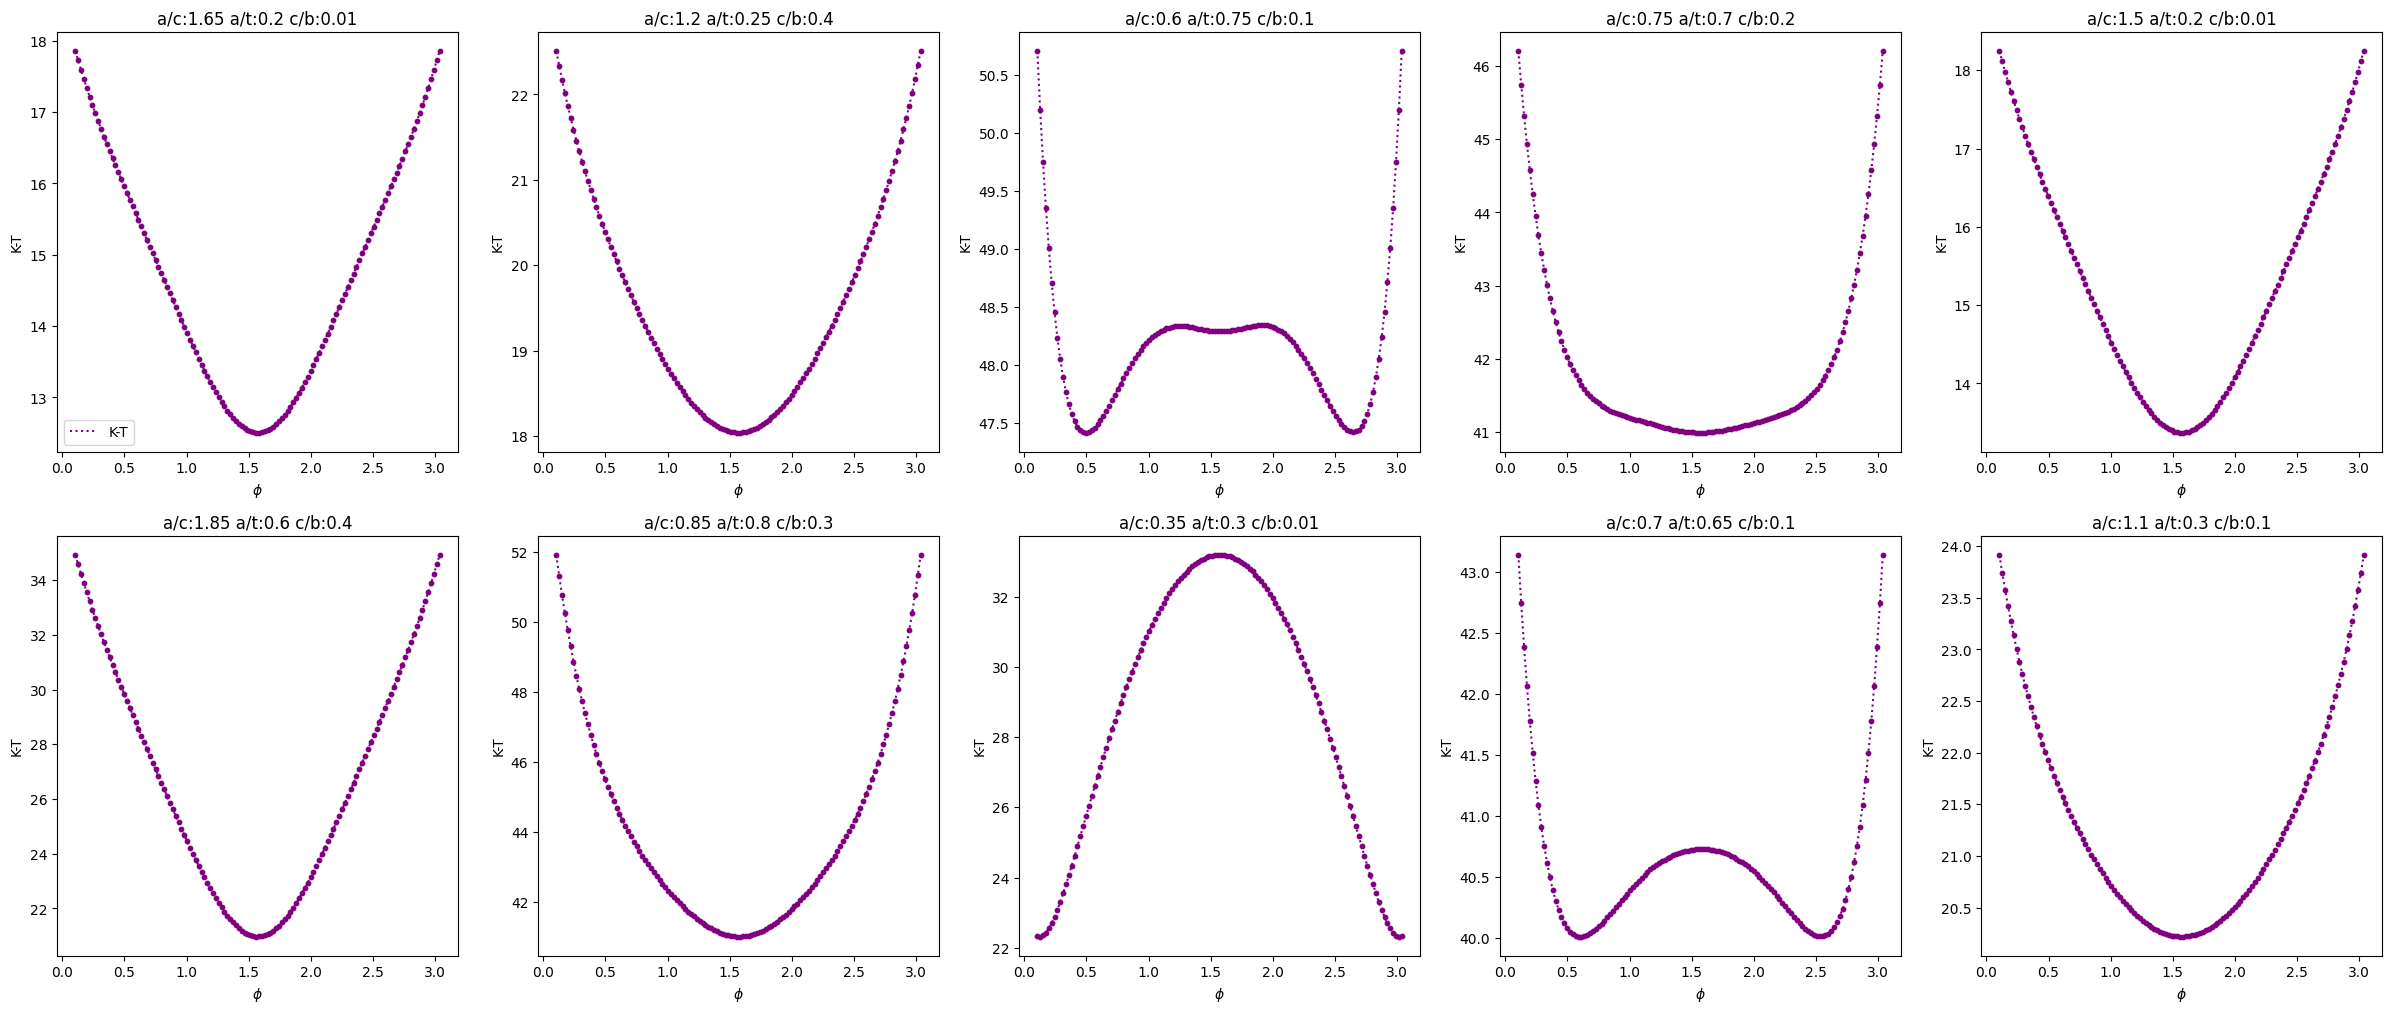

In [34]:
import matplotlib.pyplot as plt
np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(SC_train_combinations))
        a_c = SC_train_combinations[idx][0]
        a_t = SC_train_combinations[idx][1]
        c_b = SC_train_combinations[idx][2]

        indices = np.where((d[:, 0] == a_c) & 
                    (d[:, 1] == a_t) &
                    (d[:, 2] == c_b)) 
        indices = indices[0]

        axs[i,j].scatter(d[indices][:,-2], d[indices][:,-1], color='purple', s=10)
        axs[i,j].plot(phi_deeponet, y_deeponet[idx], label="K-T", color='purple', linestyle=":")

        axs[i,j].set_title("a/c:{} a/t:{} c/b:{}".format(a_c, a_t, c_b))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [35]:
device = 'cuda'

In [36]:
X_train_gpu = torch.FloatTensor(X_deeponet[:int(0.8*len(X_deeponet))]).to(device)
X_val_gpu = torch.FloatTensor(X_deeponet[int(0.8*len(X_deeponet)):]).to(device)

y_train_gpu = torch.FloatTensor(y_deeponet[:int(0.8*len(y_deeponet))]).to(device)
y_val_gpu = torch.FloatTensor(y_deeponet[int(0.8*len(y_deeponet)):]).to(device)

phi_gpu = torch.FloatTensor(np.expand_dims(phi_deeponet, axis=-1)).to(device)

X_train_gpu.shape, y_train_gpu.shape, X_val_gpu.shape, y_val_gpu.shape, phi_gpu.shape

(torch.Size([2014, 3]),
 torch.Size([2014, 128]),
 torch.Size([504, 3]),
 torch.Size([504, 128]),
 torch.Size([128, 1]))

In [37]:
branch_layers = [X_train_gpu.shape[1]] + [100, 100, 100, 100, 100, 100, 100, 100, 100]
trunk_layers = [1] + [100, 100, 100, 100, 100, 100, 100, 100, 100]

EPOCHS = 250000
lr = 1e-4

model = DeepONet(branch_layers, trunk_layers, 128, device)
model.train_model(X_train_gpu, phi_gpu, y_train_gpu, X_val_gpu, phi_gpu, y_val_gpu, lr, EPOCHS, "../files/trained_models/SURFACE_CRACK/", "deeponet")

DeepONet Training: 100%|██████████| 250000/250000 [10:24<00:00, 400.12it/s, Train NRMSE=0.0003, Test NRMSE=0.0004, Train NMSE=0.0000, Test NMSE=0.0000, Tolerance=3997]


Training finished.
Best Test NRMSE: 0.00036874 at epoch 246001


In [38]:
np.save("../files/metrics/SURFACE_CRACK/deeponet_train_nrmse.npy", model.train_nrmse)
np.save("../files/metrics/SURFACE_CRACK/deeponet_val_nrmse.npy", model.test_nrmse)

np.save("../files/metrics/SURFACE_CRACK/deeponet_train_nmse.npy", model.train_nmse)
np.save("../files/metrics/SURFACE_CRACK/deeponet_val_nmse.npy", model.test_nmse)

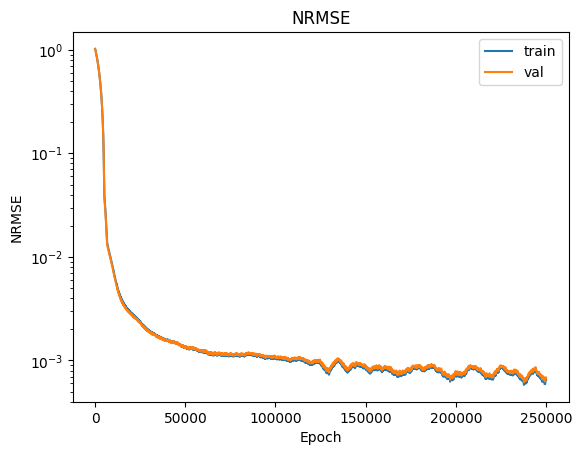

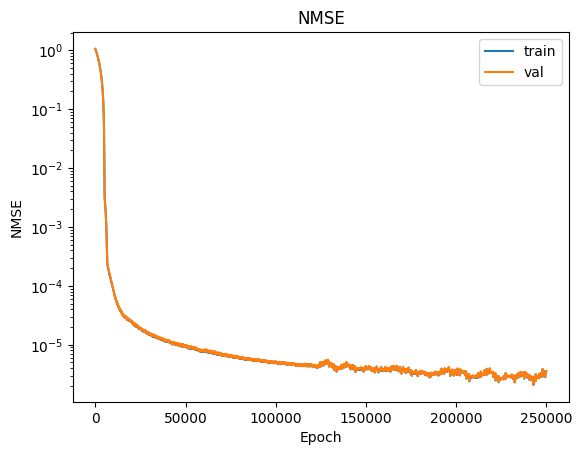

In [39]:
def running_mean(data, window_size):
    """Calculates the running mean of a list or numpy array."""
    if window_size <= 1:
        return data # No smoothing needed

    # Use convolution for efficient running mean calculation
    # Add padding to handle the beginning of the data
    padded_data = np.pad(data, (window_size - 1, 0), mode='edge')
    weights = np.ones(window_size) / window_size
    return np.convolve(padded_data, weights, mode='valid')

plt.plot(running_mean(model.train_nrmse, 5000), label="train")
plt.plot(running_mean(model.test_nrmse, 5000), label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NRMSE")
plt.title("NRMSE")
plt.semilogy()
plt.show()

plt.plot(running_mean(model.train_nmse, 5000), label="train")
plt.plot(running_mean(model.test_nmse, 5000), label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NMSE")
plt.title("NMSE")
plt.semilogy()
plt.show()

# FNO

In [40]:
from src.fno import FNO

In [41]:
X_fno = np.zeros((len(SC_train_combinations), 128, 4))
y_fno = np.zeros((len(SC_train_combinations), 128))

for (i, combination) in enumerate(SC_train_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    assert (phi_values == d[indices][:,-2]).all()
    
    X_fno[i,:,:-1] = combination
    X_fno[i,:,-1] = phi_values

    y_fno[i,:] = d[indices][:,-1]

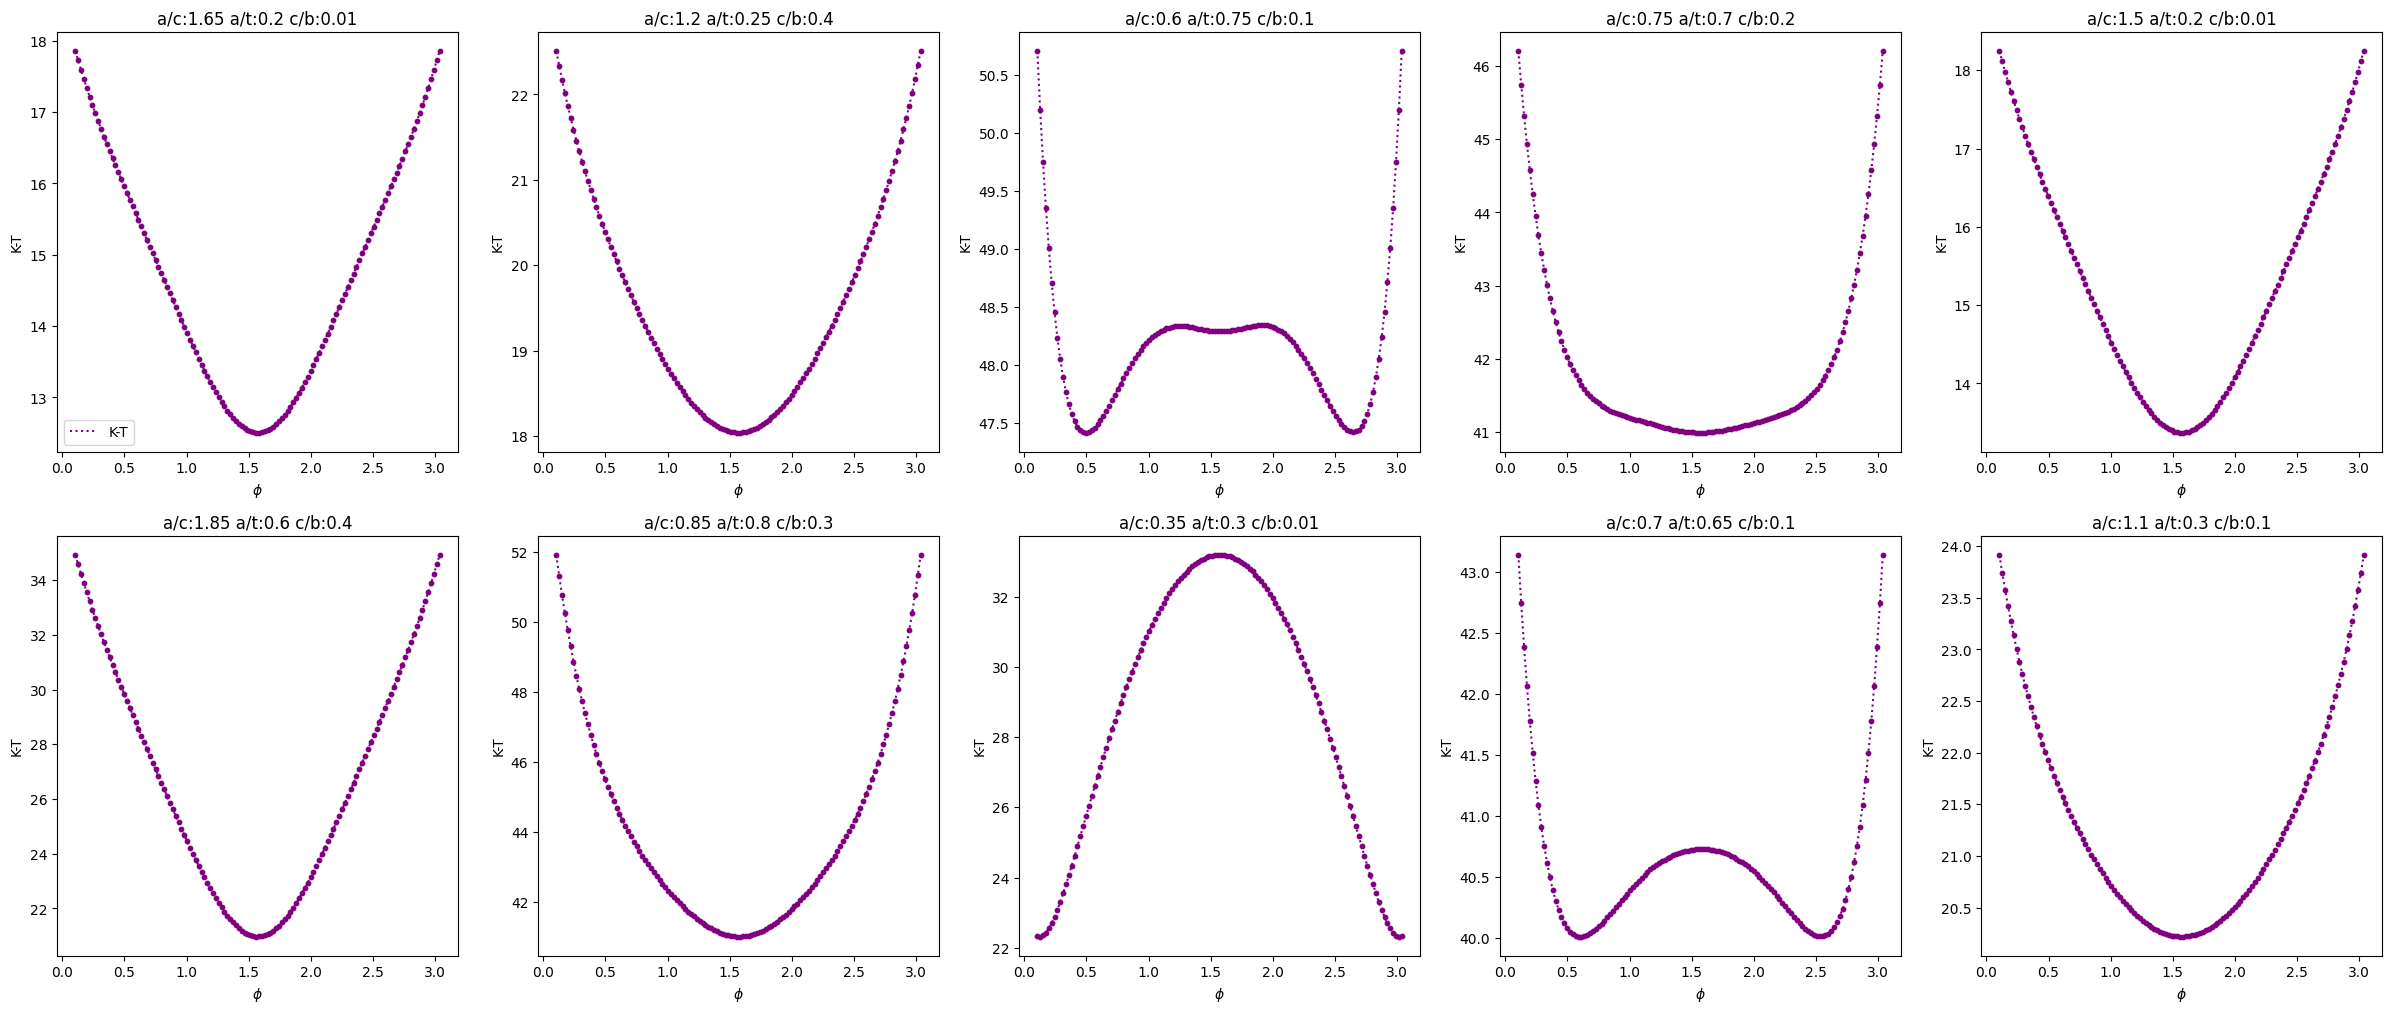

In [42]:
import matplotlib.pyplot as plt
np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(SC_train_combinations))
        a_c = SC_train_combinations[idx][0]
        a_t = SC_train_combinations[idx][1]
        c_b = SC_train_combinations[idx][2]

        indices = np.where((d[:, 0] == a_c) & 
                    (d[:, 1] == a_t) &
                    (d[:, 2] == c_b)) 
        indices = indices[0]

        axs[i,j].scatter(d[indices][:,-2], d[indices][:,-1], color='purple', s=10)
        axs[i,j].plot(phi_values, y_fno[idx], label="K-T", color='purple', linestyle=":")

        axs[i,j].set_title("a/c:{} a/t:{} c/b:{}".format(a_c, a_t, c_b))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [43]:
batch_size = 20
lr = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 64
width = 64

device = 'cuda'

In [44]:
X_train_gpu = torch.FloatTensor(X_fno[:int(0.8*len(X_fno))]).to(device)
X_val_gpu = torch.FloatTensor(X_fno[int(0.8*len(X_fno)):]).to(device)

y_train_gpu = torch.FloatTensor(y_fno[:int(0.8*len(y_fno))]).to(device)
y_val_gpu = torch.FloatTensor(y_fno[int(0.8*len(y_fno)):]).to(device)

X_train_gpu.shape, y_train_gpu.shape, X_val_gpu.shape, y_val_gpu.shape

(torch.Size([2014, 128, 4]),
 torch.Size([2014, 128]),
 torch.Size([504, 128, 4]),
 torch.Size([504, 128]))

In [45]:
fno_model = FNO(len(phi_values), X_train_gpu.shape[-1], modes, width, device)
fno_model.train_model(X_train_gpu, y_train_gpu, X_val_gpu, y_val_gpu, batch_size, lr, step_size, gamma, epochs, "../files/trained_models/SURFACE_CRACK/", "sc")

FNO Training:   0%|          | 0/500 [00:00<?, ?it/s]

FNO Training: 100%|██████████| 500/500 [02:32<00:00,  3.27it/s, Train NRMSE=0.00100456, Test NRMSE=0.00061879, Best Test NRMSE=0.00050926]


Training finished.
Best Test NRMSE: 0.00050926 at epoch 498


In [46]:
np.save("../files/metrics/SURFACE_CRACK/fno_train_nrmse.npy", fno_model.train_nrmse)
np.save("../files/metrics/SURFACE_CRACK/fno_val_nrmse.npy", fno_model.test_nrmse)

np.save("../files/metrics/SURFACE_CRACK/fno_train_nmse.npy", fno_model.train_nmse)
np.save("../files/metrics/SURFACE_CRACK/fno_val_nmse.npy", fno_model.test_nmse)

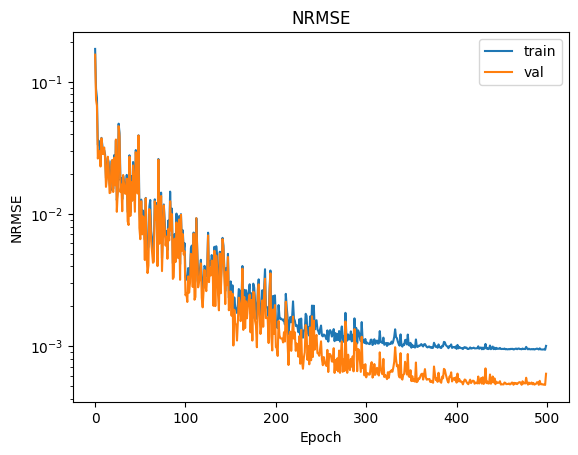

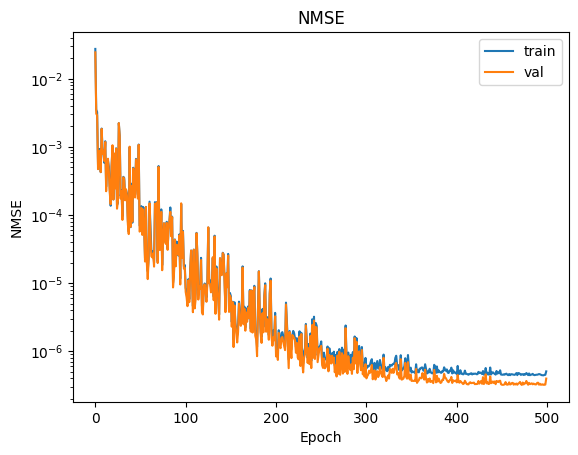

In [47]:
plt.plot(fno_model.train_nrmse, label="train")
plt.plot(fno_model.test_nrmse, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NRMSE")
plt.title("NRMSE")
plt.semilogy()
plt.show()

plt.plot(fno_model.train_nmse, label="train")
plt.plot(fno_model.test_nmse, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NMSE")
plt.title("NMSE")
plt.semilogy()
plt.show()

# POD-DeepONet

In [48]:
from src.pod_deeponet import POD_DeepONet

In [49]:
X_deeponet = np.zeros((len(SC_train_combinations), 3))
y_deeponet = np.zeros((len(SC_train_combinations), 128))

for (i,combination) in enumerate(SC_train_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    X_deeponet[i,0] = combination[0]
    X_deeponet[i,1] = combination[1]
    X_deeponet[i,2] = combination[2]

    y_deeponet[i,:] = d[indices][:,-1]

In [50]:
branch_layers = [SC_train_combinations.shape[1]] + [128, 128, 128]
lr = 1e-4
K = 128
epochs = 250000
device = 'cuda'

In [51]:
X_train_gpu = torch.FloatTensor(X_deeponet[:int(0.8*len(X_deeponet))]).to(device)
X_val_gpu = torch.FloatTensor(X_deeponet[int(0.8*len(X_deeponet)):]).to(device)

y_train_gpu = torch.FloatTensor(y_deeponet[:int(0.8*len(y_deeponet))]).to(device)
y_val_gpu = torch.FloatTensor(y_deeponet[int(0.8*len(y_deeponet)):]).to(device)

X_train_gpu.shape, y_train_gpu.shape, X_val_gpu.shape, y_val_gpu.shape

(torch.Size([2014, 3]),
 torch.Size([2014, 128]),
 torch.Size([504, 3]),
 torch.Size([504, 128]))

In [52]:
model = POD_DeepONet(y_train_gpu, branch_layers, K, device)
model.train_model(X_train_gpu, y_train_gpu, X_val_gpu, y_val_gpu, lr, epochs, 
            "../files/trained_models/SURFACE_CRACK/", "sc")

POD-DeepONet Training: 100%|██████████| 250000/250000 [05:05<00:00, 819.67it/s, Tr NRMSE=0.00028757, Te NRMSE=0.00036164, Tr NMSE=0.00000019, Te NMSE=0.00000021, Best Te NRMSE=0.00036084] 


Training finished.
Best Test NRMSE: 0.00036084 at epoch 249858


In [53]:
np.save("../files/metrics/SURFACE_CRACK/pod-deeponet_train_nrmse.npy", model.train_nrmse)
np.save("../files/metrics/SURFACE_CRACK/pod-deeponet_val_nrmse.npy", model.test_nrmse)

np.save("../files/metrics/SURFACE_CRACK/pod-deeponet_train_nmse.npy", model.train_nmse)
np.save("../files/metrics/SURFACE_CRACK/pod-deeponet_val_nmse.npy", model.test_nmse)

np.save("../files/trained_models/SURFACE_CRACK/y_train.npy", y_train_gpu.detach().cpu().numpy())

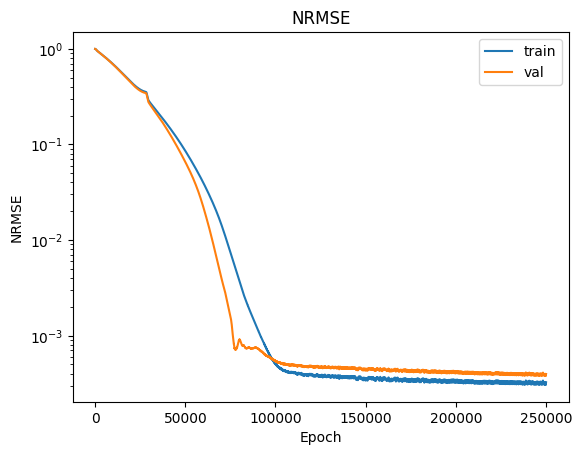

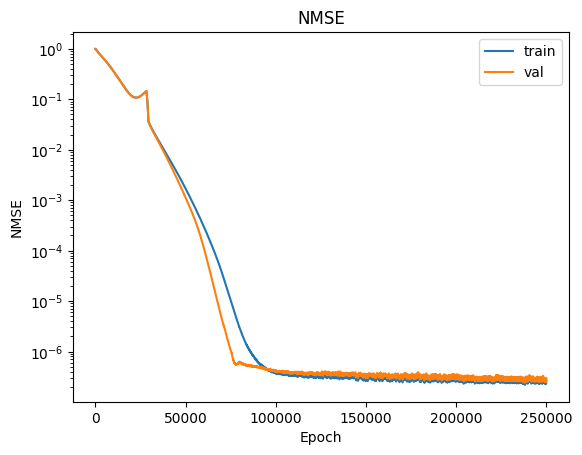

In [54]:
def running_mean(data, window_size):
    """Calculates the running mean of a list or numpy array."""
    if window_size <= 1:
        return data # No smoothing needed

    # Use convolution for efficient running mean calculation
    # Add padding to handle the beginning of the data
    padded_data = np.pad(data, (window_size - 1, 0), mode='edge')
    weights = np.ones(window_size) / window_size
    return np.convolve(padded_data, weights, mode='valid')

plt.plot(running_mean(model.train_nrmse, 1000), label="train")
plt.plot(running_mean(model.test_nrmse, 1000), label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NRMSE")
plt.title("NRMSE")
plt.semilogy()
plt.show()

plt.plot(running_mean(model.train_nmse, 1000), label="train")
plt.plot(running_mean(model.test_nmse, 1000), label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("NMSE")
plt.title("NMSE")
plt.semilogy()
plt.show()